In [75]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Libraries

In [76]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as npimg
import os


import cv2
import pandas as pd
import random
import ntpath

## Sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split



import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
#from RAdam import radam

import cv2
import matplotlib.image as mpimg
import numpy as np
import csv
import requests
import zipfile
import time
import pandas as pd
import ntpath

# Create Data Frame

In [77]:
datadir = '/content/drive/MyDrive/trial'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
df1 = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)
df1.head()

<ipython-input-77-0029ae7bb969>:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,center,left,right,steering,throttle,reverse,speed
0,C:\Users\MN\Desktop\img_capture\IMG\center_2023_09_28_12_09_38_044.jpg,C:\Users\MN\Desktop\img_capture\IMG\left_2023_09_28_12_09_38_044.jpg,C:\Users\MN\Desktop\img_capture\IMG\right_2023_09_28_12_09_38_044.jpg,0.0,0.000000,0.0,0.000025
1,C:\Users\MN\Desktop\img_capture\IMG\center_2023_09_28_12_09_38_111.jpg,C:\Users\MN\Desktop\img_capture\IMG\left_2023_09_28_12_09_38_111.jpg,C:\Users\MN\Desktop\img_capture\IMG\right_2023_09_28_12_09_38_111.jpg,0.0,0.000000,0.0,0.000015
2,C:\Users\MN\Desktop\img_capture\IMG\center_2023_09_28_12_09_38_187.jpg,C:\Users\MN\Desktop\img_capture\IMG\left_2023_09_28_12_09_38_187.jpg,C:\Users\MN\Desktop\img_capture\IMG\right_2023_09_28_12_09_38_187.jpg,0.0,0.000000,0.0,0.000003
3,C:\Users\MN\Desktop\img_capture\IMG\center_2023_09_28_12_09_38_257.jpg,C:\Users\MN\Desktop\img_capture\IMG\left_2023_09_28_12_09_38_257.jpg,C:\Users\MN\Desktop\img_capture\IMG\right_2023_09_28_12_09_38_257.jpg,0.0,0.000000,0.0,0.000007
4,C:\Users\MN\Desktop\img_capture\IMG\center_2023_09_28_12_09_38_325.jpg,C:\Users\MN\Desktop\img_capture\IMG\left_2023_09_28_12_09_38_325.jpg,C:\Users\MN\Desktop\img_capture\IMG\right_2023_09_28_12_09_38_325.jpg,0.0,0.159388,0.0,0.050384


# Remove the prefix part throughout the dataset

In [78]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail

df1['center'] = df1['center'].apply(path_leaf)
df1['left'] = df1['left'].apply(path_leaf)
df1['right'] = df1['right'].apply(path_leaf)
df1.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2023_09_28_12_09_38_044.jpg,left_2023_09_28_12_09_38_044.jpg,right_2023_09_28_12_09_38_044.jpg,0.0,0.000000,0.0,0.000025
1,center_2023_09_28_12_09_38_111.jpg,left_2023_09_28_12_09_38_111.jpg,right_2023_09_28_12_09_38_111.jpg,0.0,0.000000,0.0,0.000015
2,center_2023_09_28_12_09_38_187.jpg,left_2023_09_28_12_09_38_187.jpg,right_2023_09_28_12_09_38_187.jpg,0.0,0.000000,0.0,0.000003
3,center_2023_09_28_12_09_38_257.jpg,left_2023_09_28_12_09_38_257.jpg,right_2023_09_28_12_09_38_257.jpg,0.0,0.000000,0.0,0.000007
4,center_2023_09_28_12_09_38_325.jpg,left_2023_09_28_12_09_38_325.jpg,right_2023_09_28_12_09_38_325.jpg,0.0,0.159388,0.0,0.050384


# Create Data Frame Containing center and steering only

In [79]:
df = df1.iloc[:, [0,3,4]]

In [80]:
df.head()

,center,steering,throttle
0,center_2023_09_28_12_09_38_044.jpg,0.0,0.000000
1,center_2023_09_28_12_09_38_111.jpg,0.0,0.000000
2,center_2023_09_28_12_09_38_187.jpg,0.0,0.000000
3,center_2023_09_28_12_09_38_257.jpg,0.0,0.000000
4,center_2023_09_28_12_09_38_325.jpg,0.0,0.159388


# Image Visualization

In [81]:
def load_image(image_file):
    """
    Load image from File
    """
    data_dir_img='/content/drive/MyDrive/trial/IMG'
    return mpimg.imread(os.path.join(data_dir_img, image_file.strip()))


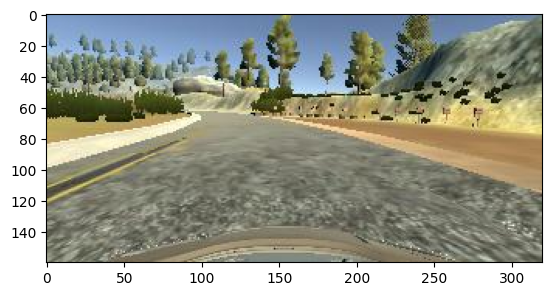

In [82]:
rand_image = df['center'][100]
rand_image = load_image(rand_image)
plt.imshow(rand_image)

# distribution of the steering wheel angle values

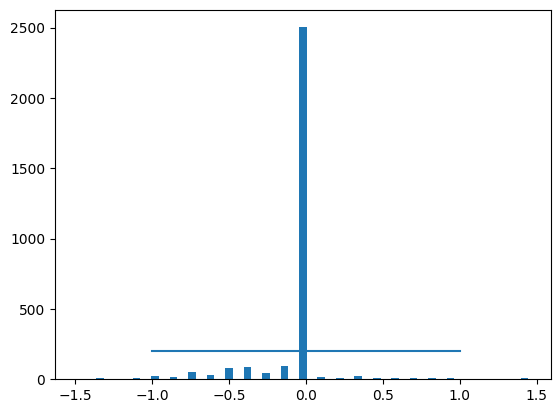

In [83]:
num_bins = 25
samples_per_bin = 200
hist, bins = np.histogram(df['steering'], num_bins)
center = bins[:-1] + bins[1:] * 0.5  # center the bins to 0

plt.bar(center, hist, width=0.05)
plt.plot((np.min(df['steering']), np.max(df['steering'])), (samples_per_bin, samples_per_bin))


Conclusion : Most of the time the car is driving straight meaning there is bias so i will need to shuffle the dataset.

# Image Preprocessing

In [84]:
def crop(image):
    """
    Crop the image
    """
    return image[60:135,:,:]  # remove the sky and the car front


def resize(image):
    """
    Resize the image to the input shape used by the network model
    """
    return cv2.resize(image, (200, 66), cv2.INTER_AREA)


def rgb2yuv(image):
    """
    Convert the image from RGB to YUV (This is what the NVIDIA model does)
    """
    return cv2.cvtColor(image, cv2.COLOR_RGB2YUV)


def preprocess(image):
    """
    Combine all preprocess functions into one
    """
    image = crop(image)
    image = resize(image)
    image = rgb2yuv(image)
    #img=img/255
    return image



# Image Augmentation

In [85]:
def random_flip(image, steering_angle):
    """
    Randomly flipt the image left <-> right, and adjust the steering angle.
    """
    if np.random.rand() < 0.5:
        image = cv2.flip(image, 1)
        steering_angle = -steering_angle
    return image, steering_angle

def random_translate(image, steering_angle, range_x, range_y):
    """
    Randomly shift the image virtially and horizontally (translation).
    """
    trans_x = range_x * (np.random.rand() - 0.5)
    trans_y = range_y * (np.random.rand() - 0.5)
    steering_angle += trans_x * 0.002
    trans_m = np.float32([[1, 0, trans_x], [0, 1, trans_y]])
    height, width = image.shape[:2]
    image = cv2.warpAffine(image, trans_m, (width, height))
    return image, steering_angle
def random_brightness(image):
    """
    Randomly adjust brightness of the image.
    """
    # HSV (Hue, Saturation, Value) is also called HSB ('B' for Brightness).
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    ratio = 1.0 + 0.4 * (np.random.rand() - 0.5)
    hsv[:,:,2] =  hsv[:,:,2] * ratio
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

In [86]:
def augument(center,steering_angle, range_x=100, range_y=10):
    """
    Generate an augumented image and adjust steering angle.
    """
    image = load_image(center)
    image, steering_angle = random_flip(image, steering_angle)
    #image, steering_angle = random_translate(image, steering_angle, range_x, range_y)
    image = random_brightness(image)
    return image, steering_angle


# Create a CustomDataset

In [87]:
class CustomDataset(data.Dataset):

    def __init__(self,df, image_dir, transform = None):
        self.df=df
        self.image_dir = image_dir
        self.transform = transform

    def __getitem__(self, index):
        center= self.df["center"][index]
        steering_angle = float(self.df["steering"][index])
        throttle = float(self.df["throttle"][index])

        if np.random.rand() < 0.5:
            image, steering_angle = augument(center,steering_angle)
        else:
            image = load_image(center)

        image = preprocess(image)

        if self.transform is not None:
            image = self.transform(image)

        return image, steering_angle , throttle

    def __len__(self):
        return len(self.df)

# Data Loader

In [88]:
batch_size = 128
num_epochs = 30
validation_split = 0.20
shuffle_dataset = True
random_seed = 42
num_workers = 4

In [89]:
print("Initializing Datasets and Dataloaders...")
# Apply some transformations
transformations = transforms.Compose([transforms.Lambda(lambda x: (x / 255.0) - 0.5)])
#Create a dataset object
dataset = CustomDataset(df,'/content/drive/MyDrive/trial/IMG', transformations)
dataset_size = len(dataset)
# Creating data indices for training and validation splits
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
#Shuffle data to avoid bias
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                           sampler=train_sampler, num_workers=num_workers)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler, num_workers=num_workers)

data_loader_dict = {
    'train': train_loader,
    'val': validation_loader
}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


#**First Approach**


1.  We add a Convolutional layer with 3 filters kernel_size= 5x5 use Elu activation function stride =2
2.  We add a Maxpooling
3.  We add a second convolutional layer of 24 filters of 5x5 kernel size, with stride 2x2 and elu activation function.
4.  We add a second convolutional layer of 36 filters of 5x5 kernel size, with stride 2x2 and elu activation function.
5. We add 3 FC layers and a prodoupt in between.




In [90]:
data_loader_dict = {
    'train': train_loader,
    'val': validation_loader
}

In [91]:
class DriverNet(nn.Module):

  def __init__(self):
        super(DriverNet, self).__init__()


        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 24, kernel_size=5, stride=2),
            nn.ELU(),
            nn.MaxPool2d(2),
            nn.Conv2d(24, 36, kernel_size=5, stride=2),
            nn.ELU(),
            nn.Conv2d(36, 48, kernel_size=5, stride=2),
            nn.ELU(),
            nn.Flatten()

        )
        self.linear_layers = nn.Sequential(
            nn.Linear(in_features=48*1*10, out_features=100),
            nn.ELU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=100, out_features=64),
            nn.ELU(),
            nn.Linear(in_features=64, out_features=2)
        )
  def forward(self, input):
      input = input.view(input.size(0), 3, 66, 200)
      output = self.conv_layers(input)
      output = output.view(output.size(0), -1)
      output = self.linear_layers(output)
      return output

In [92]:
model_ft = DriverNet()

# Send the model to GPU
model_ft = model_ft.to(device)


params_to_update = model_ft.parameters()
print("Params to learn:")

for name,param in model_ft.named_parameters():
    if param.requires_grad == True:
        print("\t",name)


optimizer_ft = optim.Adam(params_to_update, lr = 0.0001)
#optimizer_ft = optim.SGD(params_to_update, lr = 0.0001)
# optimizer_ft = optim.Adam(params_to_update, lr = 0.0001)

Params to learn:
	 conv_layers.0.weight
	 conv_layers.0.bias
	 conv_layers.3.weight
	 conv_layers.3.bias
	 conv_layers.5.weight
	 conv_layers.5.bias
	 linear_layers.0.weight
	 linear_layers.0.bias
	 linear_layers.3.weight
	 linear_layers.3.bias
	 linear_layers.5.weight
	 linear_layers.5.bias


In [93]:
def toDevice(data, device):

  return data.float().to(device)

# Train Model

In [94]:
def toDevice(data, device):

  return data.float().to(device)

In [95]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    epoch_number, train_losses, val_losses,  = [], [], []
    best_loss = 10000.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        epoch_number.append(epoch)
        # Each epoch has a training and validation phase
        # Training loop
        train_loss = 0.0
        val_loss = 0.0

        # Training
        model.train()
        for inputs, labels1, labels2 in dataloaders['train']:
          inputs = toDevice(inputs, device)
          labels1 = toDevice(labels1, device)
          labels2 = toDevice(labels2, device)

          optimizer.zero_grad()
    # Generate predictions
          outputs = model(inputs)
          out1, out2 = torch.split(outputs, 1, dim=1)  # Split the outputs into two tensors

          loss1 = criterion(out1, labels1.unsqueeze(1))
          loss2 = criterion(out2, labels2.unsqueeze(1))
          loss = loss1 + loss2
          loss.backward()
          optimizer.step()
          train_loss += loss.item()
        # Validation
        model.eval()
        with torch.no_grad():
          for inputs, labels1, labels2 in dataloaders['val']:
            inputs = toDevice(inputs, device)
            labels1 = toDevice(labels1, device)
            labels2 = toDevice(labels2, device)
            outputs = model(inputs)
            out1, out2 = torch.split(outputs, 1, dim=1)  # Split the outputs into two tensors

            loss1 = criterion(out1, labels1.unsqueeze(1))
            loss2 = criterion(out2, labels2.unsqueeze(1))
            loss = loss1 + loss2

            #print(labels.unsqueeze(1))

            val_loss += loss.item()

        # Average validation loss
        train_loss = train_loss / len(dataloaders['train'])
        val_loss = val_loss / len(dataloaders['val'])

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print('Train Loss: {:.4f}'.format(train_loss))
        print('Val Loss: {:.4f}'.format(val_loss))

        # If the validation loss is at a minimum
        if val_loss < best_loss:
          # Save the model
          torch.save(model, 'model.h5')
          best_loss = val_loss

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Lead val Loss: {:4f}'.format(best_loss))

    #creating dataframe and record all the losses and accuracies at each epoch
    log_frame = pd.DataFrame(columns = ["Epoch", "Train Loss", "Test Loss"])
    log_frame["Epoch"] = epoch_number
    log_frame["Train Loss"] = train_losses
    log_frame["Test Loss"] = val_losses
    log_frame.to_csv(os.path.join("/content/drive/MyDrive/trial", "log2.csv"), index = False)

    # load best model weights
    # model.load_state_dict(best_model_wts)
    return model

In [96]:
data_loader_dict = {
    'train': train_loader,
    'val': validation_loader
}

In [97]:
criterion = nn.MSELoss()

# Train and evaluate
model_ft = train_model(model_ft, data_loader_dict, criterion, optimizer_ft, num_epochs=num_epochs)


Epoch 0/29
----------
Train Loss: 0.4154
Val Loss: 0.1926
Epoch 1/29
----------
Train Loss: 0.2145
Val Loss: 0.1923
Epoch 2/29
----------
Train Loss: 0.1999
Val Loss: 0.1829
Epoch 3/29
----------
Train Loss: 0.1961
Val Loss: 0.1808
Epoch 4/29
----------
Train Loss: 0.1974
Val Loss: 0.1799
Epoch 5/29
----------
Train Loss: 0.1880
Val Loss: 0.1779
Epoch 6/29
----------
Train Loss: 0.1853
Val Loss: 0.1752
Epoch 7/29
----------
Train Loss: 0.1902
Val Loss: 0.1743
Epoch 8/29
----------
Train Loss: 0.1838
Val Loss: 0.1757
Epoch 9/29
----------
Train Loss: 0.1818
Val Loss: 0.1706
Epoch 10/29
----------
Train Loss: 0.1841
Val Loss: 0.1692
Epoch 11/29
----------
Train Loss: 0.1820
Val Loss: 0.1749
Epoch 12/29
----------
Train Loss: 0.1768
Val Loss: 0.1652
Epoch 13/29
----------
Train Loss: 0.1726
Val Loss: 0.1640
Epoch 14/29
----------
Train Loss: 0.1773
Val Loss: 0.1629
Epoch 15/29
----------
Train Loss: 0.1701
Val Loss: 0.1665
Epoch 16/29
----------
Train Loss: 0.1672
Val Loss: 0.1568
Epoch 1

# Results

In [98]:
frame = pd.read_csv(os.path.join("/content/drive/MyDrive/trial", "log2.csv"))
frame

,Epoch,Train Loss,Test Loss
0,0,0.415355,0.192563
1,1,0.214525,0.192339
2,2,0.199940,0.182880
3,3,0.196110,0.180793
4,4,0.197362,0.179879
5,5,0.187990,0.177916
6,6,0.185281,0.175229
7,7,0.190241,0.174339
8,8,0.183795,0.175655
9,9,0.181788,0.170561


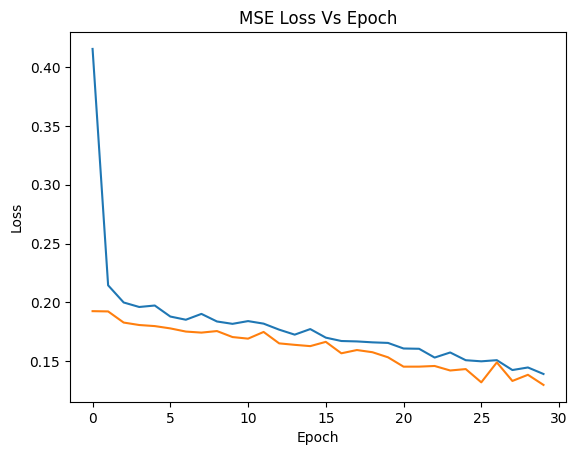

In [99]:
from matplotlib import pyplot as plt
from matplotlib import style

from numpy import genfromtxt

data = genfromtxt(os.path.join("/content/drive/MyDrive/trial", "log2.csv"),delimiter=',', names=['Epoch', 'Train Loss', 'Test Loss'])
epoch_list = []
train_loss_list = []
test_loss_list = []
for row in data:
  if not np.isnan(row[0]):
    epoch_list.append(row[0])
    train_loss_list.append(row[1])
    test_loss_list.append(row[2])


plt.plot(epoch_list, train_loss_list, label = "Training Loss")
plt.plot(epoch_list, test_loss_list, label = "Testing Loss")

plt.title('MSE Loss Vs Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.show()

# Second Approach

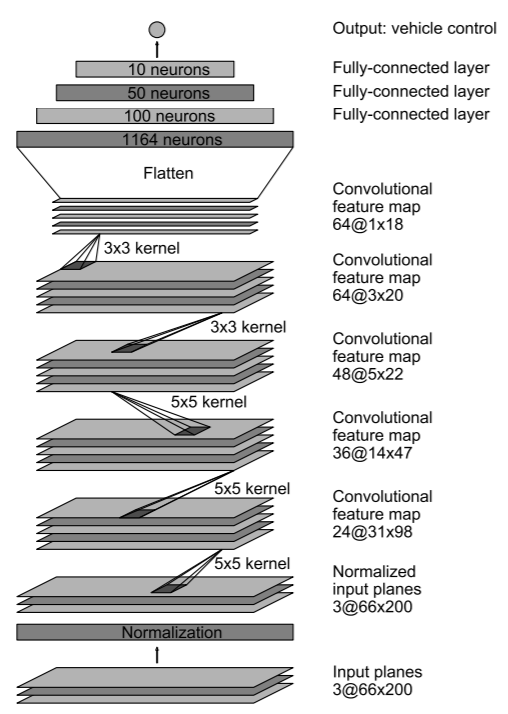

In [100]:
batch_size = 128
num_epochs = 39
validation_split = 0.20
shuffle_dataset = True
random_seed = 42
num_workers = 4

In [101]:
data_loader_dict = {
    'train': train_loader,
    'val': validation_loader
}

In [102]:
class DriverNet(nn.Module):

  def __init__(self):
        super(DriverNet, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 24, kernel_size=5, stride=2),
            nn.ELU(),
            nn.Conv2d(24, 36, kernel_size=5, stride=2),
            nn.ELU(),
            nn.Conv2d(36, 48, kernel_size=5, stride=2),
            nn.ELU(),
            nn.Conv2d(48, 64, kernel_size=3, stride=1),
            nn.ELU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ELU(),
            nn.Dropout(p=0.5)
        )
        self.linear_layers = nn.Sequential(
            nn.Linear(in_features=64*1*18, out_features=100),
            nn.ELU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=100, out_features=64),
            nn.ELU(),
            nn.Linear(in_features=64, out_features=10),
            nn.ELU(),
            nn.Linear(in_features=10, out_features=2)
        )


  def forward(self, input):
      input = input.view(input.size(0), 3, 66, 200)
      output = self.conv_layers(input)
      output = output.view(output.size(0), -1)
      output = self.linear_layers(output)
      return output


# Observe Paramters to be optimized

In [103]:
model_ft = DriverNet()

# Send the model to GPU
model_ft = model_ft.to(device)

params_to_update = model_ft.parameters()
print("Params to learn:")

for name,param in model_ft.named_parameters():
    if param.requires_grad == True:
        print("\t",name)
optimizer_ft = optim.Adam(params_to_update, lr = 0.0001)


Params to learn:
	 conv_layers.0.weight
	 conv_layers.0.bias
	 conv_layers.2.weight
	 conv_layers.2.bias
	 conv_layers.4.weight
	 conv_layers.4.bias
	 conv_layers.6.weight
	 conv_layers.6.bias
	 conv_layers.8.weight
	 conv_layers.8.bias
	 linear_layers.0.weight
	 linear_layers.0.bias
	 linear_layers.3.weight
	 linear_layers.3.bias
	 linear_layers.5.weight
	 linear_layers.5.bias
	 linear_layers.7.weight
	 linear_layers.7.bias


In [104]:
def toDevice(data, device):

  return data.float().to(device)

In [105]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    epoch_number, train_losses, val_losses,  = [], [], []
    best_loss = 10000.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        epoch_number.append(epoch)
        # Each epoch has a training and validation phase
        # Training loop
        train_loss = 0.0
        val_loss = 0.0

        # Training
        model.train()
        for inputs, labels1, labels2 in dataloaders['train']:
          inputs = toDevice(inputs, device)
          labels1 = toDevice(labels1, device)
          labels2 = toDevice(labels2, device)

          optimizer.zero_grad()
    # Generate predictions
          outputs = model(inputs)
          out1, out2 = torch.split(outputs, 1, dim=1)  # Split the outputs into two tensors

          loss1 = criterion(out1, labels1.unsqueeze(1))
          loss2 = criterion(out2, labels2.unsqueeze(1))
          loss = loss1 + loss2
          loss.backward()
          optimizer.step()
          train_loss += loss.item()
        # Validation
        model.eval()
        with torch.no_grad():
          for inputs, labels1, labels2 in dataloaders['val']:
            inputs = toDevice(inputs, device)
            labels1 = toDevice(labels1, device)
            labels2 = toDevice(labels2, device)
            outputs = model(inputs)
            out1, out2 = torch.split(outputs, 1, dim=1)  # Split the outputs into two tensors

            loss1 = criterion(out1, labels1.unsqueeze(1))
            loss2 = criterion(out2, labels2.unsqueeze(1))
            loss = loss1 + loss2

            #print(labels.unsqueeze(1))

            val_loss += loss.item()

        # Average validation loss
        train_loss = train_loss / len(dataloaders['train'])
        val_loss = val_loss / len(dataloaders['val'])

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print('Train Loss: {:.4f}'.format(train_loss))
        print('Val Loss: {:.4f}'.format(val_loss))

        # If the validation loss is at a minimum
        if val_loss < best_loss:
          # Save the model
          torch.save(model, 'model.h5')
          best_loss = val_loss

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Lead val Loss: {:4f}'.format(best_loss))

    #creating dataframe and record all the losses and accuracies at each epoch
    log_frame = pd.DataFrame(columns = ["Epoch", "Train Loss", "Test Loss"])
    log_frame["Epoch"] = epoch_number
    log_frame["Train Loss"] = train_losses
    log_frame["Test Loss"] = val_losses
    log_frame.to_csv(os.path.join("/content/drive/MyDrive/trial", "log2.csv"), index = False)

    # load best model weights
    # model.load_state_dict(best_model_wts)
    return model

In [106]:
data_loader_dict = {
    'train': train_loader,
    'val': validation_loader
}

In [107]:
criterion = nn.MSELoss()

# Train and evaluate
model_ft = train_model(model_ft, data_loader_dict, criterion, optimizer_ft, num_epochs=num_epochs)


Epoch 0/38
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train Loss: 0.3351
Val Loss: 0.1916
Epoch 1/38
----------
Train Loss: 0.1929
Val Loss: 0.1854
Epoch 2/38
----------
Train Loss: 0.1880
Val Loss: 0.1779
Epoch 3/38
----------
Train Loss: 0.1820
Val Loss: 0.1779
Epoch 4/38
----------
Train Loss: 0.1812
Val Loss: 0.1753
Epoch 5/38
----------
Train Loss: 0.1816
Val Loss: 0.1744
Epoch 6/38
----------
Train Loss: 0.1843
Val Loss: 0.1784
Epoch 7/38
----------
Train Loss: 0.1794
Val Loss: 0.1777
Epoch 8/38
----------
Train Loss: 0.1813
Val Loss: 0.1803
Epoch 9/38
----------
Train Loss: 0.1795
Val Loss: 0.1738
Epoch 10/38
----------
Train Loss: 0.1796
Val Loss: 0.1709
Epoch 11/38
----------
Train Loss: 0.1743
Val Loss: 0.1744
Epoch 12/38
----------
Train Loss: 0.1776
Val Loss: 0.1716
Epoch 13/38
----------
Train Loss: 0.1762
Val Loss: 0.1729
Epoch 14/38
----------
Train Loss: 0.1782
Val Loss: 0.1697
Epoch 15/38
----------
Train Loss: 0.1729
Val Loss: 0.1656
Epoch 16/38
----------
Train Loss: 0.1697
Val Loss: 0.1628
Epoch 17/38
----------
Train 

In [108]:
frame = pd.read_csv(os.path.join("/content/drive/MyDrive/trial", "log2.csv"))
frame

,Epoch,Train Loss,Test Loss
0,0,0.335085,0.191577
1,1,0.192899,0.185367
2,2,0.188032,0.177862
3,3,0.182019,0.177908
4,4,0.181239,0.175293
5,5,0.181639,0.174418
6,6,0.184332,0.178399
7,7,0.179425,0.177679
8,8,0.181317,0.180285
9,9,0.179465,0.173842


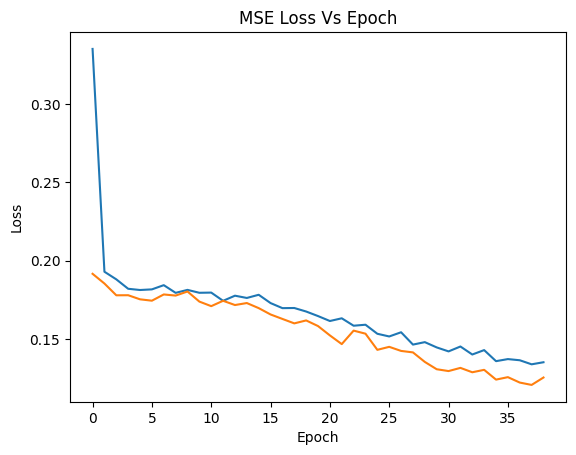

In [109]:
from matplotlib import pyplot as plt
from matplotlib import style

from numpy import genfromtxt

data = genfromtxt(os.path.join("/content/drive/MyDrive/trial", "log2.csv"),delimiter=',', names=['Epoch', 'Train Loss', 'Test Loss'])
epoch_list = []
train_loss_list = []
test_loss_list = []
for row in data:
  if not np.isnan(row[0]):
    epoch_list.append(row[0])
    train_loss_list.append(row[1])
    test_loss_list.append(row[2])


plt.plot(epoch_list, train_loss_list, label = "Training Loss")
plt.plot(epoch_list, test_loss_list, label = "Testing Loss")

plt.title('MSE Loss Vs Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.show()